In [1]:
import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt


from myrmsprop import MyRmsprop
from utils import plot_decision_boundary,attn_avg,plot_analysis
from synthetic_dataset import MosaicDataset1
from eval_model import calculate_attn_loss,analyse_data



%matplotlib inline
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
train_data = np.load("train_type4_data.npy",allow_pickle=True)

test_data = np.load("test_type4_data.npy",allow_pickle=True)

In [3]:
mosaic_list_of_images = train_data[0]["mosaic_list"]
mosaic_label = train_data[0]["mosaic_label"]
fore_idx = train_data[0]["fore_idx"]


test_mosaic_list_of_images = test_data[0]["mosaic_list"]
test_mosaic_label = test_data[0]["mosaic_label"]
test_fore_idx = test_data[0]["fore_idx"]

In [4]:
batch = 3000
train_dataset = MosaicDataset1(mosaic_list_of_images, mosaic_label, fore_idx)
train_loader = DataLoader( train_dataset,batch_size= batch ,shuffle=False)
#batch = 2000
#test_dataset = MosaicDataset1(test_mosaic_list_of_images, test_mosaic_label, test_fore_idx)
#test_loader = DataLoader(test_dataset,batch_size= batch ,shuffle=False)

In [5]:
n_batches = 3000//batch
bg = []
for i in range(n_batches):
  torch.manual_seed(i)
  betag = torch.randn(3000,9)#torch.ones((250,9))/9
  bg.append( betag.requires_grad_() )

In [6]:
len(bg)

1

In [7]:
data = np.load("dist_top1_type4.npy",allow_pickle=True)
indices = data[0]['indices'].numpy()
rows,cols = np.unravel_index(indices,shape=(27000,27000))
H = torch.zeros((27000,27000))
H[rows,cols] =1
#H = np.zeros((27000,27000))
# for i, data in enumerate(train_loader, 0):
#   print(i) # only one batch
#   inputs,_,_ = data
#   inputs = torch.reshape(inputs,(27000,2))

#   dis = (torch.cdist(inputs,inputs)**2).to(dtype=torch.float32).flatten()
  
  






In [8]:
print(indices,rows[0],cols[0])
# to check H contains only 7290000 elements
torch.sum(H)

[ 74846772 640012206 434730224 ... 280650211 180429167 507357022] 2772 2772


tensor(7290000.)

In [9]:
class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    self.linear1 = nn.Linear(2,100)
    self.linear2 = nn.Linear(100,3)

  def forward(self,x):
    x = F.relu(self.linear1(x))
    x = self.linear2(x)
    return x

In [10]:
torch.manual_seed(1234)
what_net = Module2().double()

#what_net.load_state_dict(torch.load("type4_what_net.pt"))
what_net = what_net.to("cuda")

In [11]:
# for param in what_net.parameters():
#     param.requires_grad = False

In [12]:
optim1 = []
H= H.to("cpu")
for i in range(n_batches):
  optim1.append(MyRmsprop([bg[i]],H=H,lr=1))

In [13]:
# instantiate optimizer
optimizer_what = optim.RMSprop(what_net.parameters(), lr=0.001)#, momentum=0.9)#,nesterov=True)


 


criterion = nn.CrossEntropyLoss()
acti = []
analysis_data_tr = []
analysis_data_tst = []
loss_curi_tr = []
loss_curi_tst = []
epochs = 200


# calculate zeroth epoch loss and FTPT values
running_loss,anlys_data,correct,total,accuracy = calculate_attn_loss(train_loader,bg,what_net,criterion)
print('training epoch: [%d ] loss: %.3f correct: %.3f, total: %.3f, accuracy: %.3f' %(0,running_loss,correct,total,accuracy)) 
loss_curi_tr.append(running_loss)
analysis_data_tr.append(anlys_data)




# training starts 
for epoch in range(epochs): # loop over the dataset multiple times
  ep_lossi = []
  running_loss = 0.0
  what_net.train()
  for i, data in enumerate(train_loader, 0):
    # get the inputs
    inputs, labels,_  = data
    inputs = inputs.double()
    beta = bg[i] # alpha for ith batch
    #print(labels)
    inputs, labels,beta = inputs.to("cuda"),labels.to("cuda"),beta.to("cuda")
        
    # zero the parameter gradients
    optimizer_what.zero_grad()
    optim1[i].zero_grad()
      
    # forward + backward + optimize
    avg,alpha = attn_avg(inputs,beta)
    outputs = what_net(avg)     
    loss = criterion(outputs, labels)

    # print statistics
    running_loss += loss.item()
    #alpha.retain_grad()
    loss.backward(retain_graph=False)
    optimizer_what.step()
    optim1[i].step()


  running_loss_tr,anls_data,correct,total,accuracy = calculate_attn_loss(train_loader,bg,what_net,criterion)
  analysis_data_tr.append(anls_data)
  loss_curi_tr.append(running_loss_tr)   #loss per epoch
  print('training epoch: [%d ] loss: %.3f correct: %.3f, total: %.3f, accuracy: %.3f' %(epoch+1,running_loss_tr,correct,total,accuracy)) 


  
  if running_loss_tr<=0.08:
    break
print('Finished Training run ')
analysis_data_tr = np.array(analysis_data_tr)



training epoch: [0 ] loss: 1.478 correct: 971.000, total: 3000.000, accuracy: 0.324
training epoch: [1 ] loss: 1.137 correct: 991.000, total: 3000.000, accuracy: 0.330
training epoch: [2 ] loss: 1.040 correct: 1021.000, total: 3000.000, accuracy: 0.340
training epoch: [3 ] loss: 0.975 correct: 1793.000, total: 3000.000, accuracy: 0.598
training epoch: [4 ] loss: 0.912 correct: 2003.000, total: 3000.000, accuracy: 0.668
training epoch: [5 ] loss: 0.871 correct: 2560.000, total: 3000.000, accuracy: 0.853
training epoch: [6 ] loss: 0.835 correct: 2009.000, total: 3000.000, accuracy: 0.670
training epoch: [7 ] loss: 0.805 correct: 2230.000, total: 3000.000, accuracy: 0.743
training epoch: [8 ] loss: 0.778 correct: 2009.000, total: 3000.000, accuracy: 0.670
training epoch: [9 ] loss: 0.754 correct: 2066.000, total: 3000.000, accuracy: 0.689
training epoch: [10 ] loss: 0.730 correct: 2047.000, total: 3000.000, accuracy: 0.682
training epoch: [11 ] loss: 0.701 correct: 2380.000, total: 3000.0

In [14]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_train[columns[0]] = np.arange(0,epoch+2)
df_train[columns[1]] = analysis_data_tr[:,-2]/30
df_train[columns[2]] = analysis_data_tr[:,-1]/30
df_train[columns[3]] = analysis_data_tr[:,0]/30
df_train[columns[4]] = analysis_data_tr[:,1]/30
df_train[columns[5]] = analysis_data_tr[:,2]/30
df_train[columns[6]] = analysis_data_tr[:,3]/30

In [15]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,9.800000,90.200000,3.800000,28.566667,7.966667,59.666667
1,1,49.133333,50.866667,0.100000,32.933333,16.133333,50.833333
2,2,87.233333,12.766667,26.933333,7.100000,32.000000,33.966667
3,3,96.666667,3.333333,31.500000,28.266667,34.566667,5.666667
4,4,97.133333,2.866667,66.433333,0.333333,0.033333,33.200000
...,...,...,...,...,...,...,...
196,196,99.966667,0.033333,66.900000,27.233333,0.266667,5.600000
197,197,99.966667,0.033333,66.900000,27.233333,0.266667,5.600000
198,198,100.000000,0.000000,66.766667,27.233333,0.300000,5.700000
199,199,100.000000,0.000000,66.900000,27.133333,0.266667,5.700000


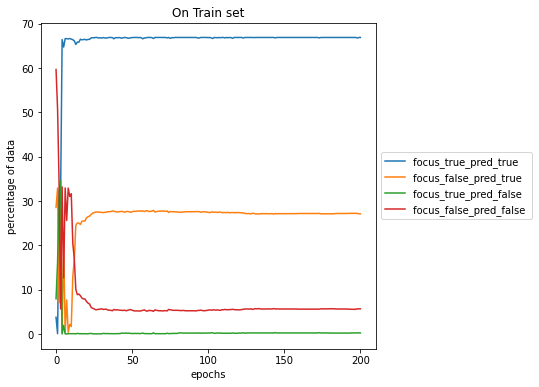

In [16]:
plot_analysis(df_train,columns)

In [17]:
aph = []
for i in bg:
  aph.append(F.softmax(i,dim=1).detach().numpy())
  
aph = np.concatenate(aph,axis=0)
# torch.save({
#             'epoch': 500,
#             'model_state_dict': what_net.state_dict(),
#             #'optimizer_state_dict': optimizer_what.state_dict(),
#             "optimizer_alpha":optim1,
#             "FTPT_analysis":analysis_data_tr,
#             "alpha":aph

#             }, "type4_what_net_500.pt")

In [18]:
aph[0]

array([0.0000000e+00, 7.2721153e-37, 0.0000000e+00, 1.0000000e+00,
       1.2173080e-41, 0.0000000e+00, 1.8081408e-25, 1.3272954e-35,
       4.2700859e-14], dtype=float32)

In [19]:
avrg = []
with torch.no_grad():
  for i, data1 in  enumerate(train_loader):
          inputs , labels , fore_idx = data1
          inputs = inputs.double()
          inputs, labels = inputs.to("cuda"),labels.to("cuda")
          beta  = bg[i]
          beta = beta.to("cuda")
          avg,alpha = attn_avg(inputs,beta)
          
          avrg.append(avg.detach().cpu().numpy())
avrg= np.concatenate(avrg,axis=0)

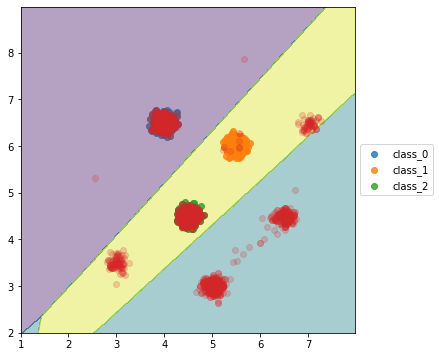

<Figure size 432x288 with 0 Axes>

In [20]:
data = np.load("type_4_data.npy",allow_pickle=True)
plot_decision_boundary(what_net,[1,8,2,9],data,bg,avrg)